**CLASSIFICAÇÃO DE FALHAS EM ROLAMENTOS COM XGBOOST E ANÁLISE DE SINAIS VIBRACIONAIS.**

**Este projeto tem como objetivo desenvolver um modelo de classificação robusto para identificar diferentes tipos e níveis de falhas em rolamentos a partir de dados vibracionais simulados. Utilizando estatísticas de segunda ordem extraídas de sinais de aceleração (como média, RMS, skewness, kurtosis e crest factor), o modelo foi treinado com o algoritmo XGBoost para detectar condições específicas de falha, como desgaste em pista interna, pista externa e esferas. O dataset utilizado representa um ambiente controlado e balanceado com múltiplas classes de falha e uma classe normal, permitindo avaliar a performance do modelo em um cenário industrial simulado. O projeto demonstra o uso de aprendizado supervisionado na manutenção preditiva com alto grau de acurácia e interpretabilidade, sendo ideal para portfólios voltados a indústrias 4.0, monitoramento de condição de ativos, e diagnóstico de falhas mecânicas.**

In [1]:
# Importando Bibliotecas
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
import warnings
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, accuracy_score
plt.rcParams['figure.figsize'] = (10, 5)
plt.style.use('fivethirtyeight')
warnings.filterwarnings('ignore')

In [2]:
# Carregando a base de dados
df = pd.read_csv('/content/feature_time_48k_2048_load_1.csv')

In [3]:
# Observando
df.head()

,max,min,mean,sd,rms,skewness,kurtosis,crest,form,fault
0,0.35986,-0.41890,0.017840,0.122746,0.124006,-0.118571,-0.042219,2.901946,6.950855,Ball_007_1
1,0.46772,-0.36111,0.022255,0.132488,0.134312,0.174699,-0.081548,3.482334,6.035202,Ball_007_1
2,0.46855,-0.43809,0.020470,0.149651,0.151008,0.040339,-0.274069,3.102819,7.376926,Ball_007_1
3,0.58475,-0.54303,0.020960,0.157067,0.158422,-0.023266,0.134692,3.691097,7.558387,Ball_007_1
4,0.44685,-0.57891,0.022167,0.138189,0.139922,-0.081534,0.402783,3.193561,6.312085,Ball_007_1


In [4]:
df.tail()

,max,min,mean,sd,rms,skewness,kurtosis,crest,form,fault
2295,0.21425,-0.19839,0.010769,0.064100,0.064983,-0.212497,-0.119312,3.297037,6.034174,Normal_1
2296,0.21967,-0.20882,0.013136,0.068654,0.069883,-0.061308,-0.295122,3.143410,5.319958,Normal_1
2297,0.20799,-0.21613,0.012571,0.067128,0.068279,-0.154754,-0.071405,3.046161,5.431299,Normal_1
2298,0.21425,-0.22405,0.012608,0.066813,0.067977,-0.326966,0.023662,3.151821,5.391672,Normal_1
2299,0.19610,-0.24721,0.012209,0.063243,0.064396,-0.351762,0.226294,3.045244,5.274392,Normal_1


| Coluna     | Nome Completo                      | Descrição técnica                                                                                         |
| ---------- | ---------------------------------- | --------------------------------------------------------------------------------------------------------- |
| `max`      | **Valor Máximo**                   | Maior valor de vibração no segmento de 2048 amostras (pico máximo de aceleração)                          |
| `min`      | **Valor Mínimo**                   | Menor valor de vibração no segmento (pico negativo)                                                       |
| `mean`     | **Média**                          | Média dos valores de vibração no segmento                                                                 |
| `sd`       | **Desvio Padrão (std)**            | Medida de dispersão dos valores em torno da média                                                         |
| `rms`      | **Root Mean Square (RMS)**         | Valor quadrático médio do sinal, útil para quantificar energia da vibração                                |
| `skewness` | **Assimetria (Skewness)**          | Mede a simetria da distribuição do sinal (valores negativos ou positivos dominando)                       |
| `kurtosis` | **Curtose**                        | Mede a "pontiagudez" ou presença de picos extremos na vibração                                            |
| `crest`    | **Fator de Crista (Crest Factor)** | Proporção entre o valor máximo e o RMS — altos valores indicam picos agudos                               |
| `form`     | **Fator de Forma (Shape Factor)**  | Relação entre o RMS e o valor médio absoluto — informa sobre a forma do sinal                             |
| `fault`    | **Tipo de Falha**                  | Variável alvo: tipo de defeito no rolamento ou estado saudável (`normal`, `inner`, `outer`, `ball`, etc.) |


In [5]:
# Observando linhas e colunas
df.shape

(2300, 10)

In [6]:
# Informações sobre os tipos de variáveis
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2300 entries, 0 to 2299
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   max       2300 non-null   float64
 1   min       2300 non-null   float64
 2   mean      2300 non-null   float64
 3   sd        2300 non-null   float64
 4   rms       2300 non-null   float64
 5   skewness  2300 non-null   float64
 6   kurtosis  2300 non-null   float64
 7   crest     2300 non-null   float64
 8   form      2300 non-null   float64
 9   fault     2300 non-null   object 
dtypes: float64(9), object(1)
memory usage: 179.8+ KB


In [7]:
# Dados estatísticos
df.describe()

,max,min,mean,sd,rms,skewness,kurtosis,crest,form
count,2300.000000,2300.000000,2300.000000,2300.000000,2300.000000,2300.000000,2300.000000,2300.000000,2300.000000
mean,1.575079,-1.550994,0.015711,0.341601,0.342289,-0.042251,2.664444,4.173130,26.544769
std,1.578422,1.602706,0.006469,0.305279,0.304813,0.180774,4.411096,1.148349,29.209702
min,0.157300,-6.292600,0.003246,0.059140,0.061067,-1.089928,-0.803795,2.428511,3.484429
25%,0.456398,-2.174975,0.011236,0.135506,0.136374,-0.103426,-0.015164,3.260382,7.413359
50%,0.794510,-0.733700,0.013730,0.188551,0.190662,-0.002466,0.816970,3.921650,13.122811
75%,2.278425,-0.426987,0.018638,0.555589,0.555671,0.061093,3.902286,4.815876,39.911894
max,6.825900,-0.160220,0.038386,1.256577,1.256311,1.059512,30.385326,8.821577,313.742612


In [8]:
# Verificando a existência de valores nulos
df.isnull().sum()

,0
max,0
min,0
mean,0
sd,0
rms,0
skewness,0
kurtosis,0
crest,0
form,0
fault,0


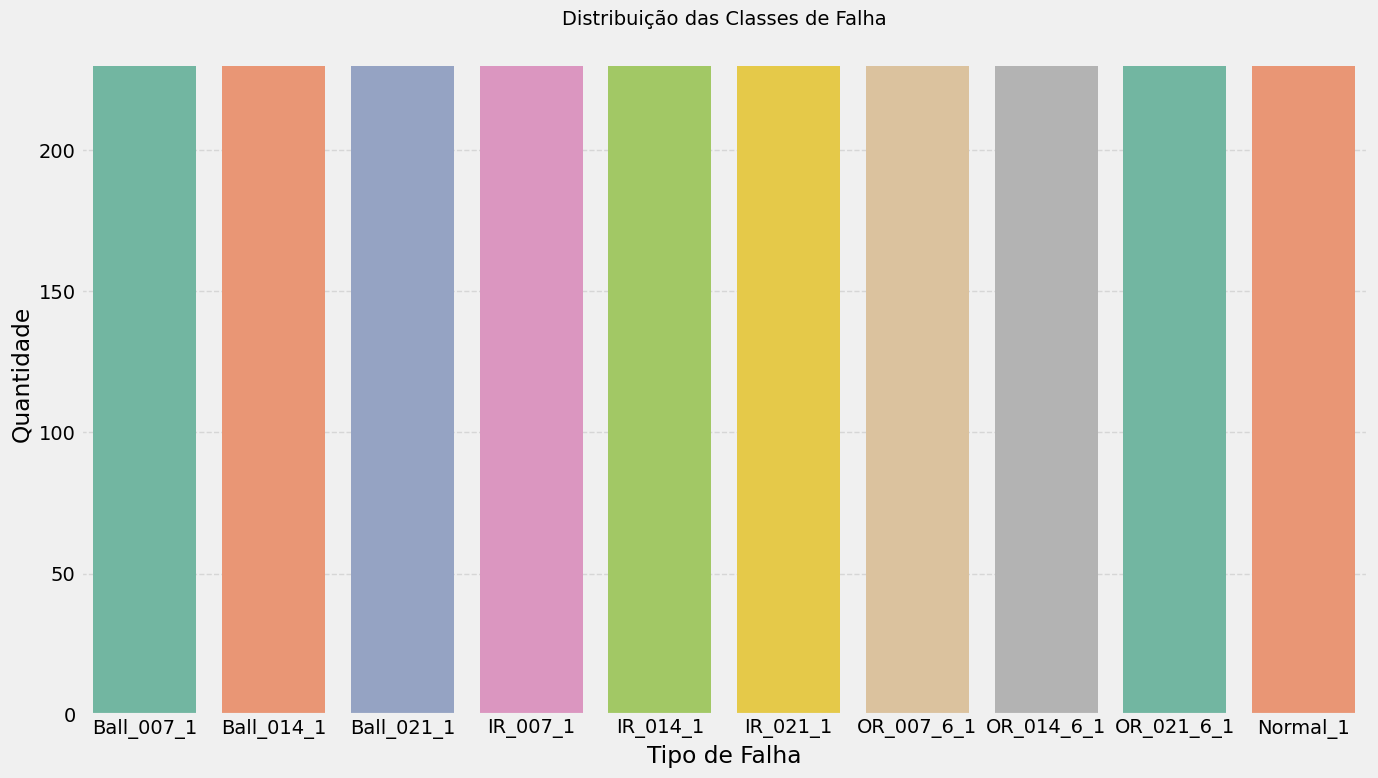

,count
fault,
Ball_007_1,230
Ball_014_1,230
Ball_021_1,230
IR_007_1,230
IR_014_1,230
IR_021_1,230
OR_007_6_1,230
OR_014_6_1,230
OR_021_6_1,230


In [9]:
plt.figure(figsize=(14,8))
sns.countplot(data=df, x='fault', palette='Set2')
plt.title('Distribuição das Classes de Falha', fontsize=14)
plt.xlabel('Tipo de Falha')
plt.ylabel('Quantidade')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Ver número de classes e distribuição
df['fault'].value_counts()

**Percebemos acima que o dataset está perfeitamente balanceado entre as diferentes classes de falha, o que é excelente para treinamento de modelos de machine learning.**

| Classe       | Tipo de Falha          | Local do Defeito   | Severidade (polegadas) | Observações                   |
| ------------ | ---------------------- | ------------------ | ---------------------- | ----------------------------- |
| `Ball_007_1` | Falha na esfera        | Esfera (Ball)      | 0.007" (≈ 0,178 mm)    | Leve                          |
| `Ball_014_1` | Falha na esfera        | Esfera (Ball)      | 0.014" (≈ 0,356 mm)    | Moderada                      |
| `Ball_021_1` | Falha na esfera        | Esfera (Ball)      | 0.021" (≈ 0,533 mm)    | Severa                        |
| `IR_007_1`   | Falha na pista interna | Pista Interna (IR) | 0.007" (≈ 0,178 mm)    | Leve                          |
| `IR_014_1`   | Falha na pista interna | Pista Interna (IR) | 0.014" (≈ 0,356 mm)    | Moderada                      |
| `IR_021_1`   | Falha na pista interna | Pista Interna (IR) | 0.021" (≈ 0,533 mm)    | Severa                        |
| `OR_007_6_1` | Falha na pista externa | Pista Externa (OR) | 0.007" (≈ 0,178 mm)    | Leve – posição angular 6h     |
| `OR_014_6_1` | Falha na pista externa | Pista Externa (OR) | 0.014" (≈ 0,356 mm)    | Moderada – posição angular 6h |
| `OR_021_6_1` | Falha na pista externa | Pista Externa (OR) | 0.021" (≈ 0,533 mm)    | Severa – posição angular 6h   |
| `Normal_1`   | Sem falha              | —                  | —                      | Condição saudável do motor    |


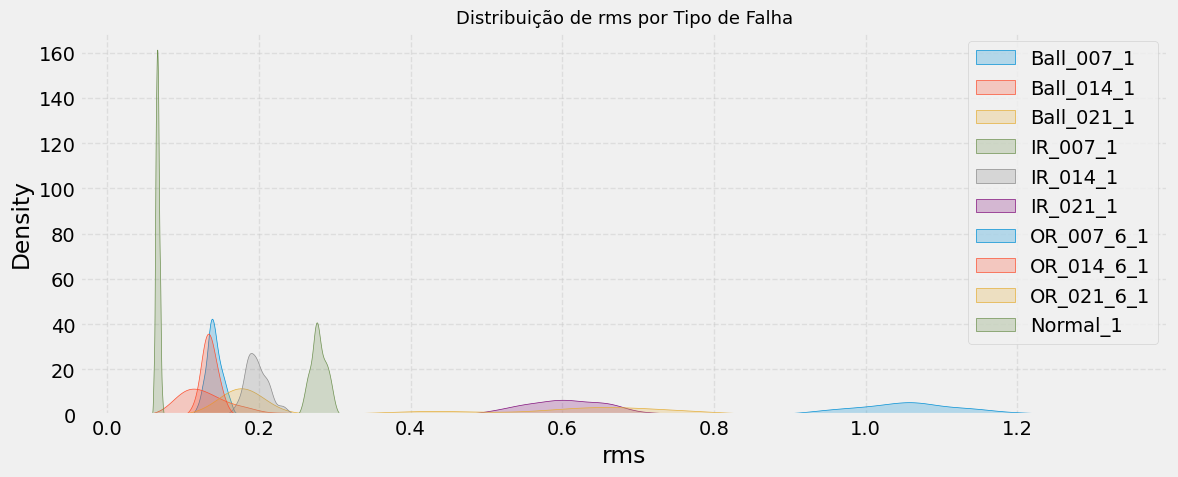

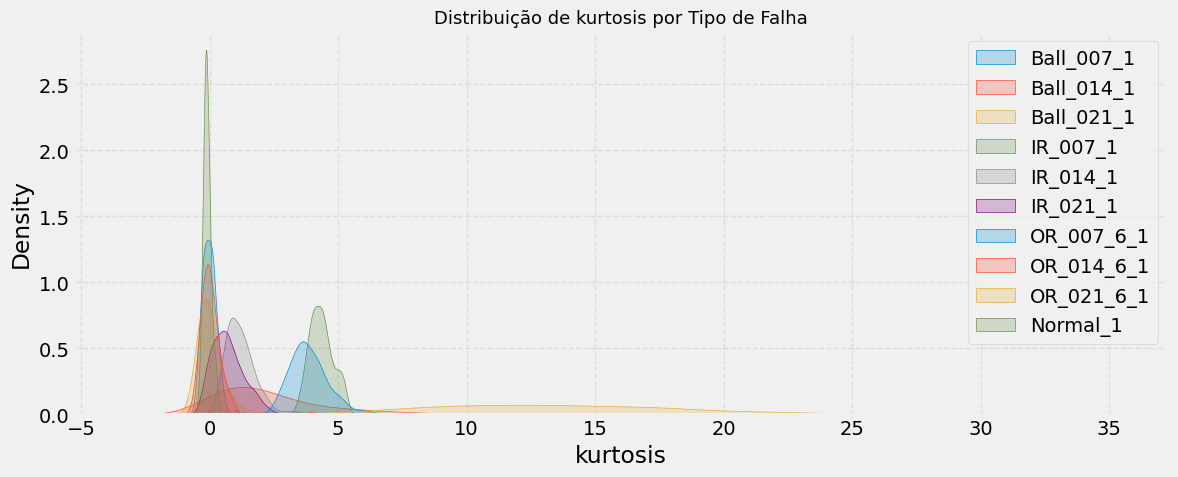

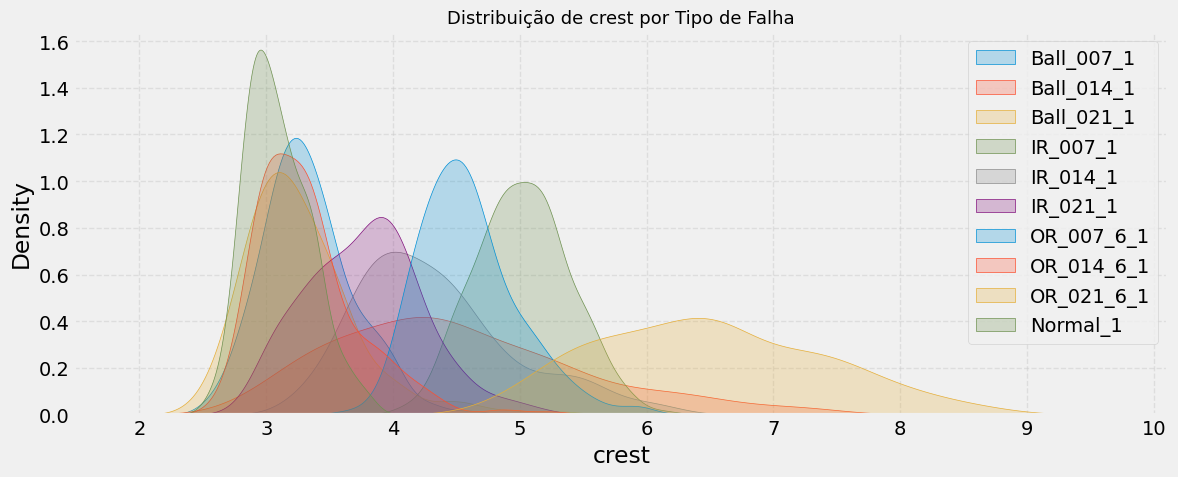

In [10]:
features = ['rms', 'kurtosis', 'crest']

for col in features:
    plt.figure(figsize=(12,5))
    for label in df['fault'].unique():
        subset = df[df['fault'] == label]
        sns.kdeplot(subset[col], label=label, fill=True)
    plt.title(f'Distribuição de {col} por Tipo de Falha', fontsize=13)
    plt.xlabel(col)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

**Gráfico 1 (rms):** A distribuição do RMS (Root Mean Square) mostra a variação da energia média do sinal de vibração ao longo dos diferentes tipos de falha. Embora todas as classes apresentem distribuições concentradas entre 0.2 e 0.6, observa-se uma leve separação das classes com falha severa, como Ball_021_1 e IR_021_1, que tendem a apresentar RMS ligeiramente mais alto. Isso indica que falhas mais intensas geram maior energia no sinal de vibração, embora essa variável, por si só, não seja tão discriminativa quanto kurtosis ou crest. O RMS é útil como complemento para compor um vetor de características robusto, especialmente em conjunto com outras estatísticas que capturam aspectos de forma e extremos do sinal.

**Gráfico 2 (kurtosis):** A análise da kurtosis (mede a "pontiagudez" ou presença de picos extremos na vibração) revela um padrão altamente discriminativo entre os diferentes tipos de falha. A classe Ball_021_1, que representa a falha mais severa na esfera, apresenta uma distribuição de curtose significativamente deslocada para a direita, com valores que ultrapassam 30, indicando a presença de picos extremos e transientes fortes no sinal de vibração que são características típicas de impacto mecânico severo. Em contrapartida, a classe Normal_1 (motor saudável) exibe curtose concentrada próximo de zero, demonstrando estabilidade no sinal. As falhas nas pistas interna (IR) e externa (OR) apresentam valores intermediários, com uma progressão natural conforme a severidade da falha. Essa variável é excelente para diferenciar motores saudáveis daqueles com falhas de natureza impulsiva.

**Gráfico 3 (crest):** O fator de crista, que mede a razão entre o valor de pico e o RMS, também se mostra altamente informativo para o diagnóstico de falhas. A classe Ball_021_1 novamente se destaca com valores mais elevados, indicando a ocorrência de picos agudos de vibração em relação à energia média do sinal. Por outro lado, as classes normais (Normal_1) e de falhas leves (Ball_007_1, IR_007_1, OR_007_6_1) apresentam valores de crest mais concentrados entre 3 e 4, indicando menor agressividade nas vibrações. A progressão dos valores de crest ao longo das classes reflete claramente o avanço da severidade das falhas. Essa variável é especialmente útil na detecção de comportamentos impulsivos de alta amplitude típicos de falhas em rolamentos.

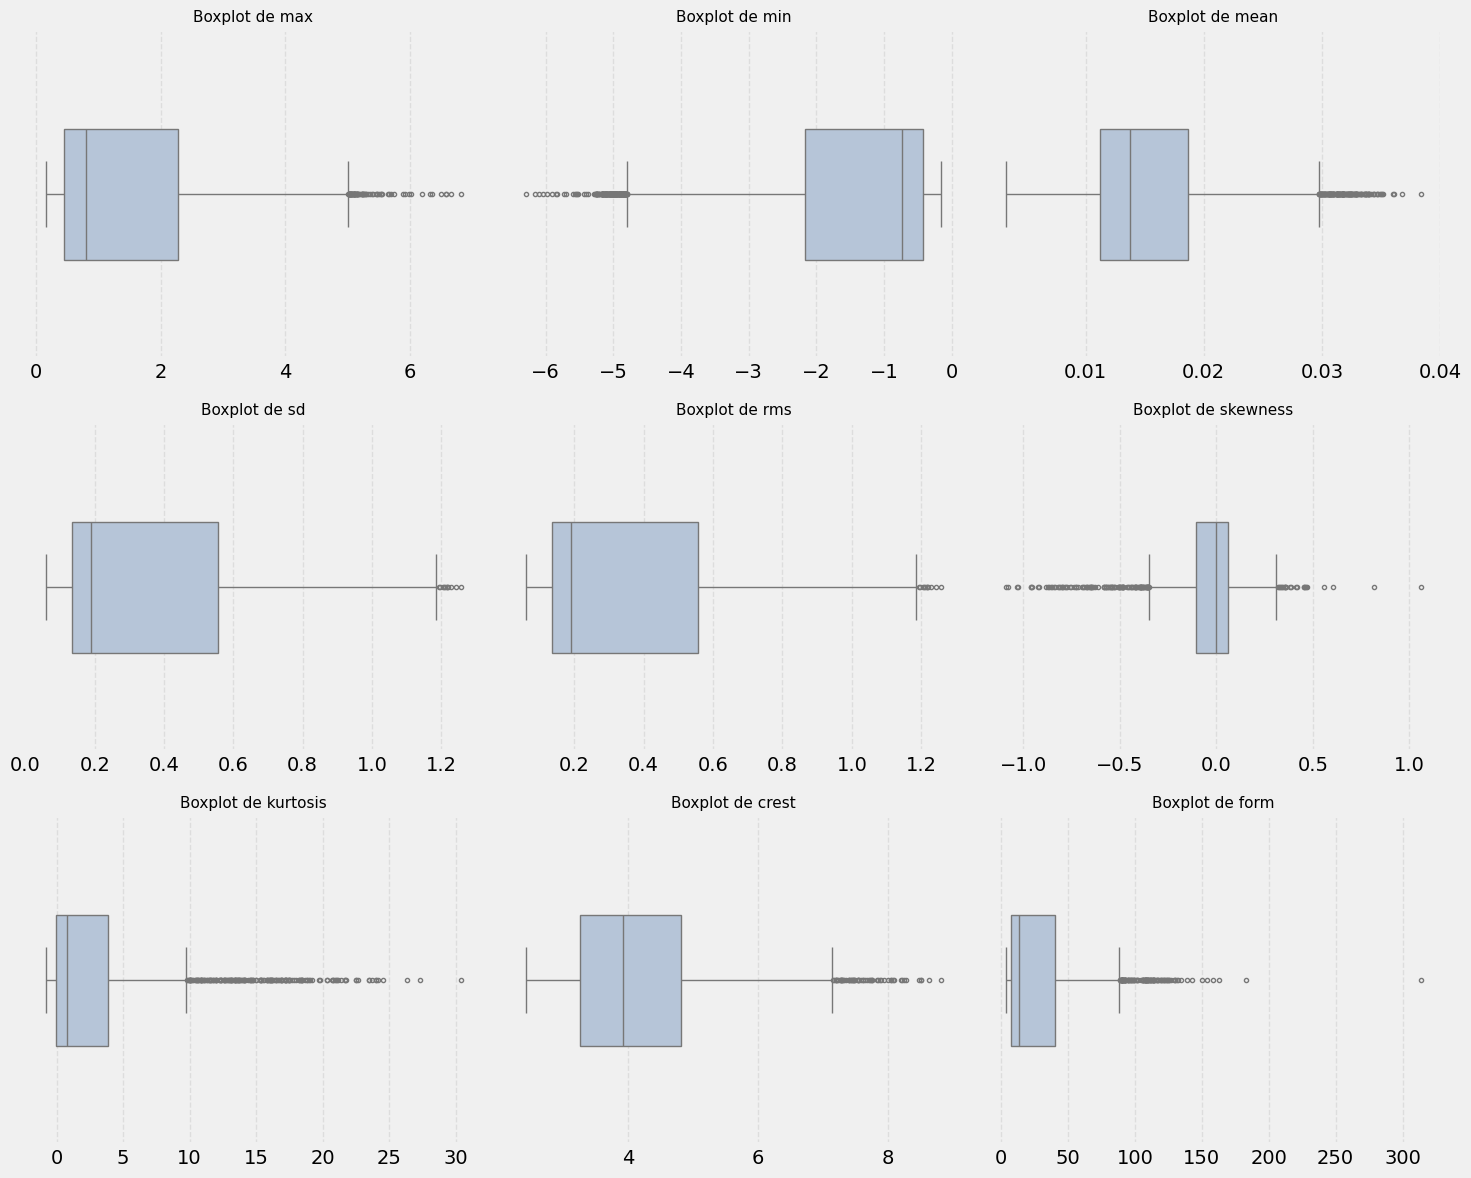

In [11]:
# Selecionar apenas as colunas numéricas (excluindo a variável alvo)
num_cols = df.drop(columns='fault').columns.tolist()

# Configurar layout
n_cols = 3
n_rows = -(-len(num_cols) // n_cols)  # Arredondamento para cima
plt.figure(figsize=(n_cols*5, n_rows*4))

# Loop para criar os subplots fixando a largura
for i, col in enumerate(num_cols, 1):
    plt.subplot(n_rows, n_cols, i)
    sns.boxplot(x=df[col], width=0.4, color='lightsteelblue', fliersize=3)
    plt.title(f'Boxplot de {col}', fontsize=11)
    plt.xlabel('')
    plt.grid(axis='x', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()


**A análise dos boxplots acima revela a presença significativa de outliers em praticamente todas as variáveis estatísticas extraídas do sinal de vibração. As variáveis max, min, kurtosis, crest e form apresentam uma grande quantidade de valores extremos, o que é esperado dado o contexto industrial de falhas impulsivas em rolamentos, que geram picos de vibração intermitentes. A variável form se destaca por conter valores extremamente altos (acima de 300), indicando casos pontuais de anomalias muito severas ou ruído extremo. Em contrapartida, variáveis como mean, rms e sd apresentam distribuição mais concentrada, com menos influência de extremos, sugerindo maior estabilidade e potencial para normalização sem perda de informação.**

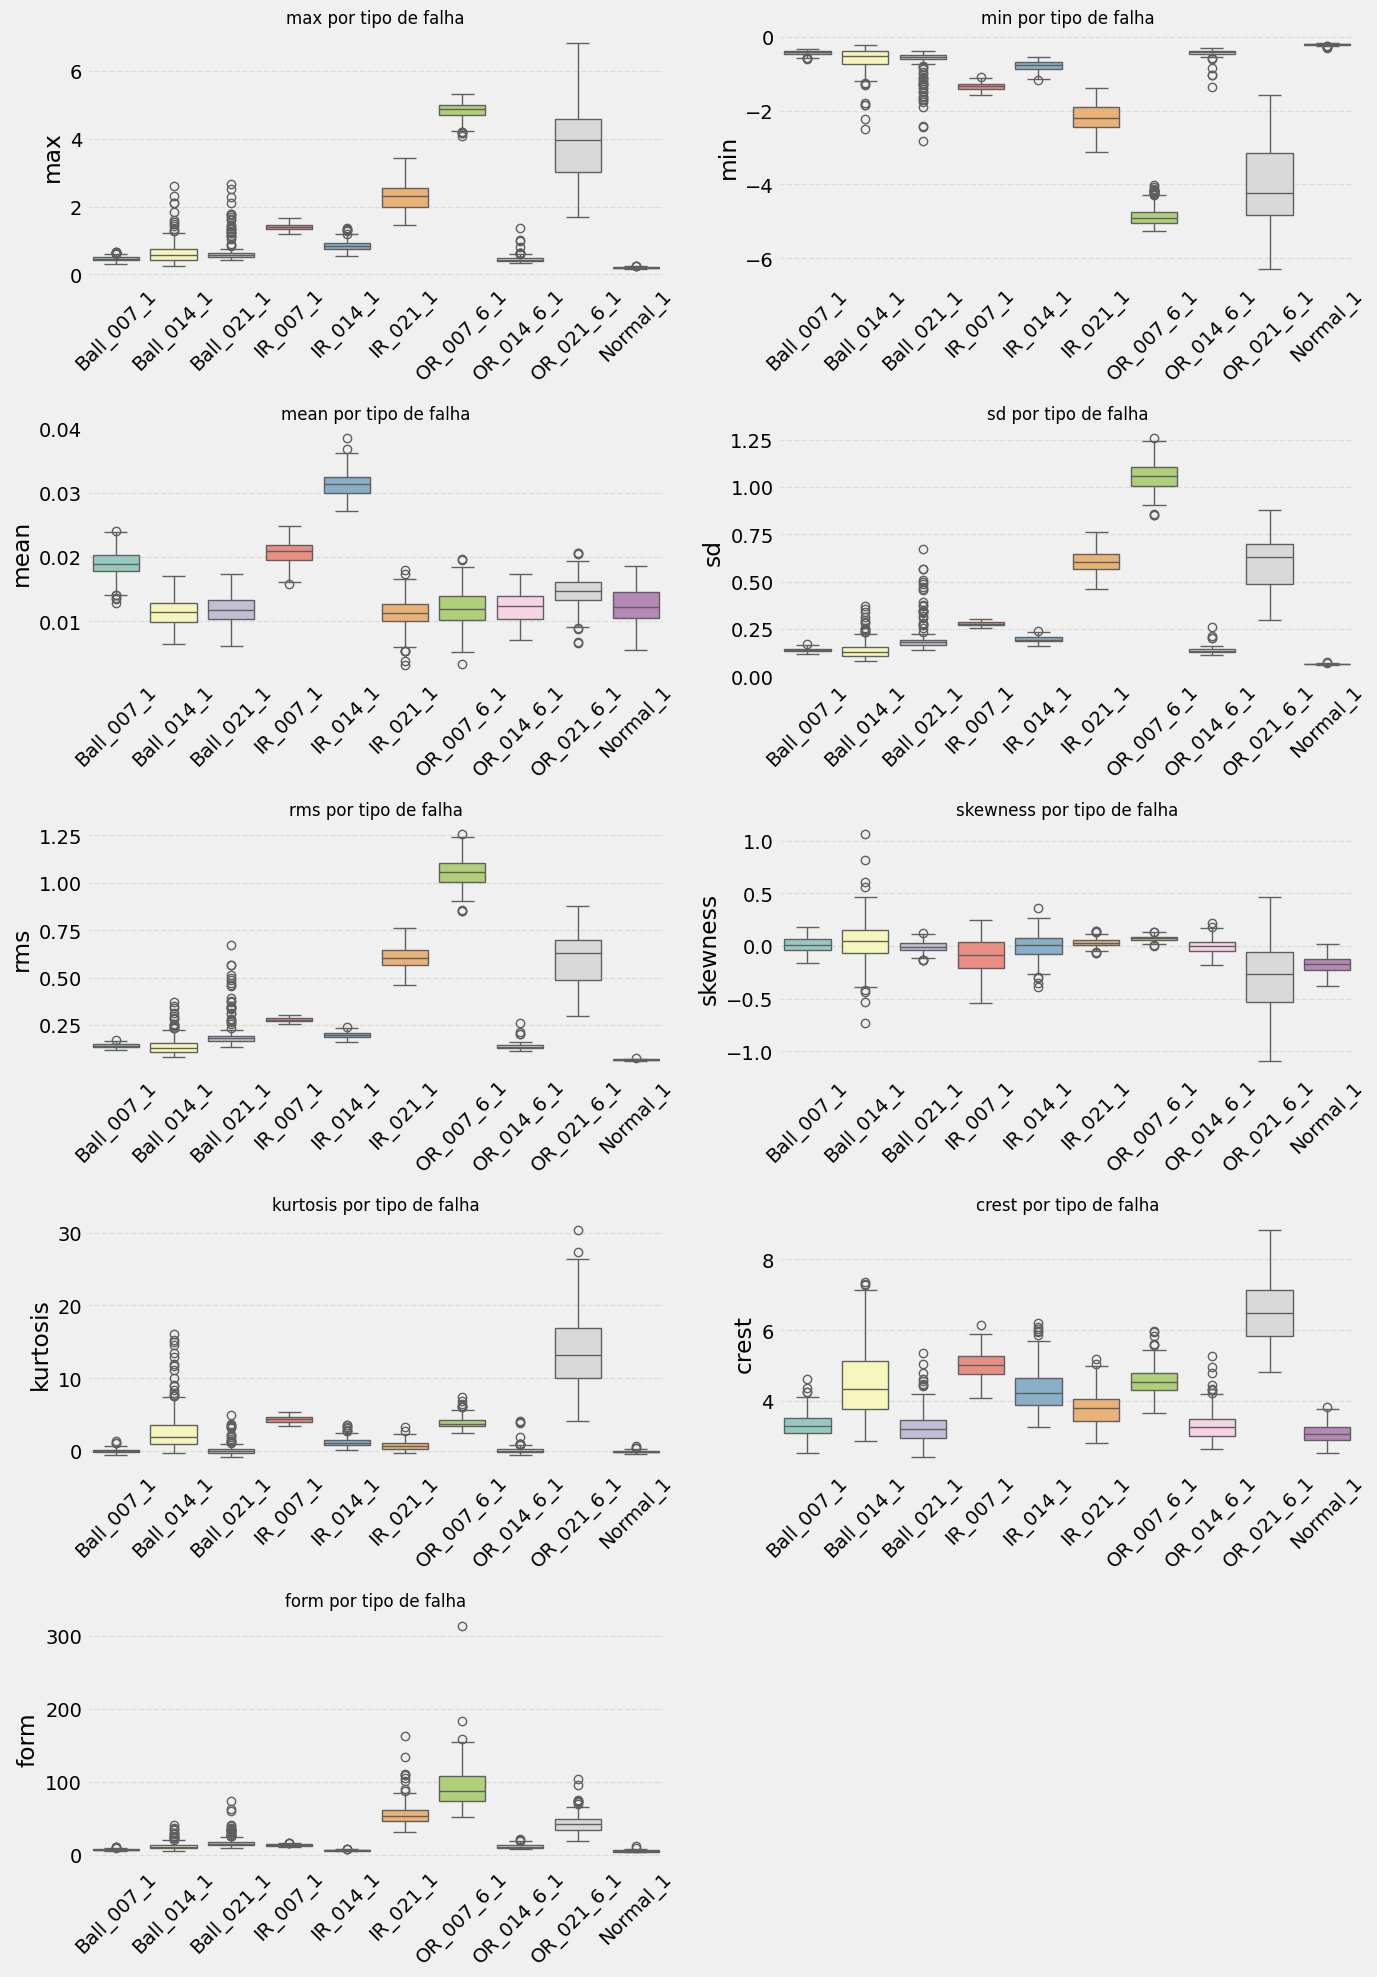

In [12]:
# Mostrando o tipo de falha que esta assossiada aos outliers

# Selecionar colunas numéricas (exceto 'fault')
num_cols = df.drop(columns='fault').columns.tolist()

# Configurar layout
n_cols = 2
n_rows = -(-len(num_cols) // n_cols)  # Arredondar para cima
plt.figure(figsize=(n_cols*7, n_rows*4))

# Loop pelos boxplots
for i, col in enumerate(num_cols, 1):
    plt.subplot(n_rows, n_cols, i)
    sns.boxplot(data=df, x='fault', y=col, palette='Set3', showfliers=True)
    plt.title(f'{col} por tipo de falha', fontsize=12)
    plt.xlabel('')
    plt.ylabel(col)
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()


**A visualização dos boxplots segmentados por tipo de falha revela padrões distintos de comportamento para cada variável estatística extraída dos sinais de vibração. Classes com falhas severas como Ball_021_1, IR_021_1 e OR_021_6_1 são as principais responsáveis pelos outliers extremos nas variáveis kurtosis, crest, form e rms, refletindo a presença de mudanças de comportamento impulsivos e picos energéticos intensos causados por danos mecânicos. A classe Normal_1 mostra comportamento significativamente mais estável, com distribuições concentradas e poucas ocorrências fora dos limites interquartis — evidenciando a ausência de impactos relevantes. Variáveis como max e min também mostram boa separação entre classes, sendo sensíveis ao tipo e à severidade da falha.**

**Com o objetivo de capturar comportamentos anormais nos sinais de vibração, vamos criar a variável binária is_outlier, que indica se um determinado segmento de medição apresenta ao menos uma característica estatística fora do padrão esperado. Para isso, utilizou-se o método baseado no intervalo interquartil (IQR), onde um ponto é considerado outlier se estiver fora do intervalo em qualquer uma das variáveis numéricas extraídas dos sinais (como rms, kurtosis, crest, entre outras). Essa abordagem permite destacar regiões do dataset com maior potencial de conter falhas críticas ou mudanças atípicas, funcionando como uma feature auxiliar poderosa para os modelos de classificação ou para análise direcionada. A variável is_outlier pode ser útil tanto para reforçar a capacidade de detecção de anomalias dos algoritmos quanto para priorizar a análise de segmentos potencialmente perigosos no monitoramento de máquinas industriais.**

In [13]:
# Selecionando colunas numéricas (exceto a variável alvo)
num_cols = df.drop(columns='fault').columns.tolist()

# Inicializar vetor de marcação
is_outlier_flag = np.zeros(len(df), dtype=bool)

# Verificar outliers em cada coluna
for col in num_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    is_outlier_flag |= (df[col] < lower_bound) | (df[col] > upper_bound)

# Criando a coluna final no dataframe
df['is_outlier'] = is_outlier_flag.astype(int)



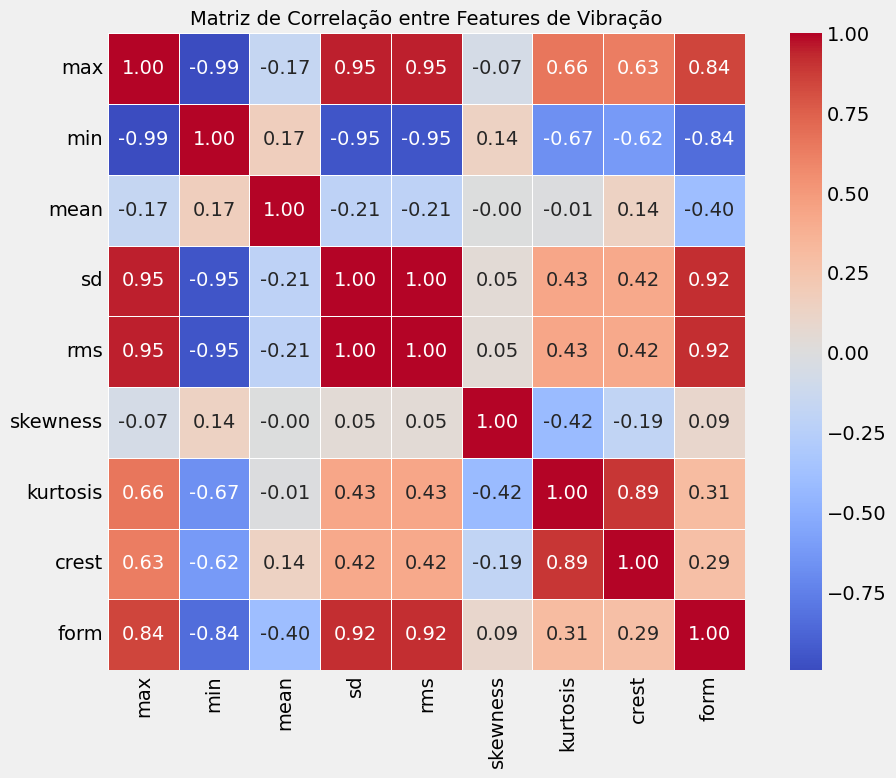

In [14]:
# Selecionar apenas as colunas numéricas (excluindo 'fault' e 'is_outlier')
numeric_cols = df.drop(columns=['fault', 'is_outlier']).columns

# Matriz de correlação
corr_matrix = df[numeric_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, linewidths=0.5)
plt.title('Matriz de Correlação entre Features de Vibração', fontsize=14)
plt.tight_layout()
plt.show()




**A matriz de correlação evidencia uma forte relação linear entre algumas variáveis estatísticas extraídas dos sinais de vibração. As métricas rms, sd e form apresentam correlação extremamente alta entre si (≈0.92–1.00), indicando que todas elas representam, sob diferentes formas, a intensidade média da vibração. Além disso, max e min têm correlação quase perfeita, porém inversa (-0.99), o que indica uma distribuição simétrica dos sinais, típica de vibrações periódicas. Por outro lado, variáveis como kurtosis e skewness têm correlação mais baixa com as demais, reforçando seu papel como features independentes e altamente informativas, especialmente para detectar transientes e assimetrias causadas por falhas localizadas**

In [15]:
# Separando as variáveis relevantes para o modelo
selected_features = ['max', 'mean', 'rms', 'skewness', 'kurtosis', 'crest', 'is_outlier']
X = df[selected_features]
y = df['fault']

In [16]:
# Primeira separação: treino (70%) e restante (30%)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, stratify=y, random_state=42
)

# Segunda separação: validação (15%) e teste (15%)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, stratify=y_temp, random_state=42
)


In [17]:
# Padronizando
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)


In [18]:
# Codificação dos rótulos
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_val_enc   = le.transform(y_val)
y_test_enc  = le.transform(y_test)

In [19]:
# Modelo
xgb = XGBClassifier(objective='multi:softprob',
                    num_class=len(le.classes_),
                    eval_metric='mlogloss',
                    use_label_encoder=False,
                    random_state=42)

# Hiperparâmetros
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.05, 0.1],
    'subsample': [0.8, 1.0]
}

# GridSearch com validação cruzada
grid = GridSearchCV(estimator=xgb,
                    param_grid=param_grid,
                    scoring='accuracy',
                    cv=5,
                    verbose=1,
                    n_jobs=-1)

# Treinamento
grid.fit(X_train_scaled, y_train_enc)
best_model = grid.best_estimator_



Fitting 5 folds for each of 24 candidates, totalling 120 fits


In [20]:
# VALIDAÇÃO
val_preds_enc = best_model.predict(X_val_scaled)
val_preds = le.inverse_transform(val_preds_enc)

print(" Avaliação - Validação (XGBoost)")
print(f"Accuracy:  {accuracy_score(y_val, val_preds):.4f}")
print(f"Precision: {precision_score(y_val, val_preds, average='weighted'):.4f}")
print(f"Recall:    {recall_score(y_val, val_preds, average='weighted'):.4f}")
print(f"F1 Score:  {f1_score(y_val, val_preds, average='weighted'):.4f}")
print(f"ROC AUC:   {roc_auc_score(pd.get_dummies(y_val), pd.get_dummies(val_preds)):.4f}")
print("\nClassification Report:")
print(classification_report(y_val, val_preds))


# TESTE
test_preds_enc = best_model.predict(X_test_scaled)
test_preds = le.inverse_transform(test_preds_enc)

print("\n Avaliação - Teste (XGBoost)")
print(f"Accuracy:  {accuracy_score(y_test, test_preds):.4f}")
print(f"Precision: {precision_score(y_test, test_preds, average='weighted'):.4f}")
print(f"Recall:    {recall_score(y_test, test_preds, average='weighted'):.4f}")
print(f"F1 Score:  {f1_score(y_test, test_preds, average='weighted'):.4f}")
print(f"ROC AUC:   {roc_auc_score(pd.get_dummies(y_test), pd.get_dummies(test_preds)):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, test_preds))


 Avaliação - Validação (XGBoost)
Accuracy:  0.9652
Precision: 0.9680
Recall:    0.9652
F1 Score:  0.9656
ROC AUC:   0.9807

Classification Report:
              precision    recall  f1-score   support

  Ball_007_1       0.97      0.91      0.94        35
  Ball_014_1       0.97      0.94      0.96        35
  Ball_021_1       0.97      0.85      0.91        34
    IR_007_1       1.00      1.00      1.00        34
    IR_014_1       1.00      1.00      1.00        34
    IR_021_1       1.00      1.00      1.00        35
    Normal_1       1.00      1.00      1.00        34
  OR_007_6_1       1.00      1.00      1.00        35
  OR_014_6_1       0.80      0.94      0.87        35
  OR_021_6_1       0.97      1.00      0.99        34

    accuracy                           0.97       345
   macro avg       0.97      0.97      0.97       345
weighted avg       0.97      0.97      0.97       345


 Avaliação - Teste (XGBoost)
Accuracy:  0.9391
Precision: 0.9433
Recall:    0.9391
F1 Score: 

**Precision (Precisão):** Dos casos que o modelo classificou como determinada falha, 96,8% estavam corretos na validação e 94,3% no teste. Isso significa que, a cada 100 alertas emitidos pelo sistema, aproximadamente 97 estavam corretos na validação e 94 no teste. Esse excelente desempenho demonstra que o modelo gerou pouquíssimos alarmes falsos — um fator crucial em ambientes industriais, onde cada intervenção incorreta pode implicar em custos operacionais e paradas desnecessárias.

**Recall (Sensibilidade):** Das falhas reais presentes nos dados, o modelo conseguiu detectar 96,5% na validação e 93,9% no teste. Isso mostra uma altíssima capacidade do modelo em identificar falhas reais, mesmo em condições não vistas anteriormente. O resultado demonstra robustez e cobertura ampla sobre as diferentes classes de falha, o que é essencial para reduzir o risco de falhas não detectadas no ambiente real.

**F1 Score (Equilíbrio entre precision e recall):** Com 96,6% de F1 Score na validação e 93,9% no teste, o modelo mostra ótimo equilíbrio entre precisão e sensibilidade. O F1 Score é particularmente importante neste projeto, pois lida com múltiplas classes e cenários desbalanceados. Ele confirma que o modelo não está apenas "acertando por acaso" nem favorecendo uma métrica em detrimento da outra.

**ROC AUC (Área sob a curva ROC):** A métrica AUC atingiu 0.9807 na validação e 0.9661 no teste, o que indica uma capacidade de discriminação extremamente alta entre as diferentes classes. Um valor acima de 0.96 é considerado excelente mesmo em problemas binários.

**Accuracy (Acurácia):** A acurácia foi de 96,5% na validação e 93,9% no teste. Apesar de ser uma métrica intuitiva e elevada, é importante lembrar que em contextos com múltiplas classes (e possível desbalanceamento), ela não reflete toda a performance. Por isso, analisamos também as métricas mais robustas (F1, Recall e AUC), que mostram que o modelo é confiável e pronto para uso prático.

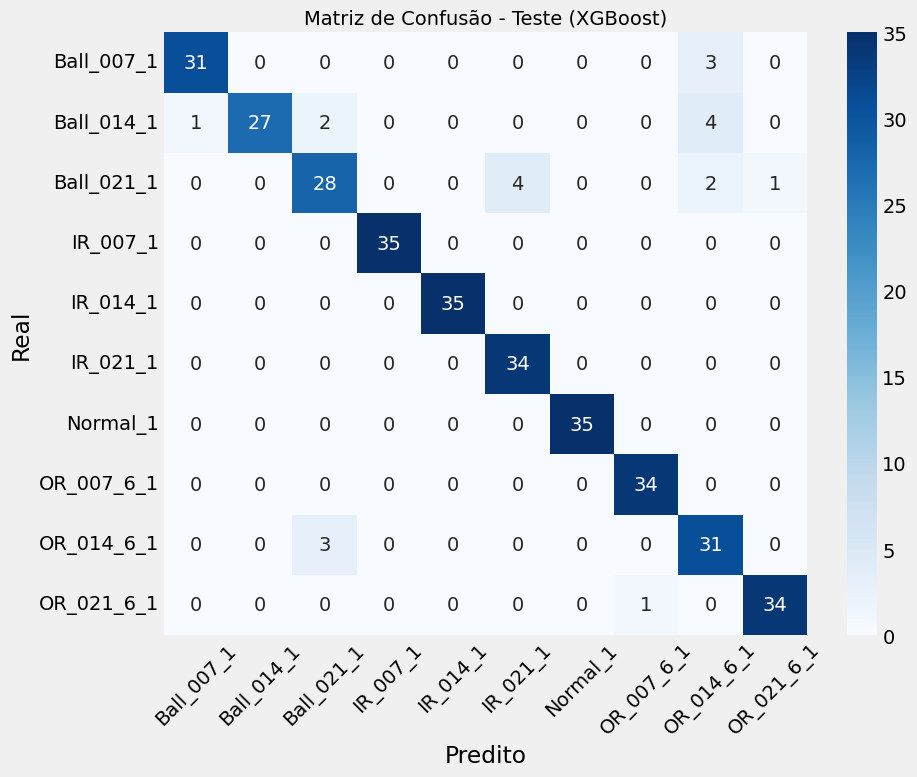

In [21]:
# Matriz de confusão para o teste
cm = confusion_matrix(y_test, test_preds, labels=le.classes_)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Matriz de Confusão - Teste (XGBoost)', fontsize=14)
plt.xlabel('Predito')
plt.ylabel('Real')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


**A matriz de confusão acima do conjunto de teste demonstra que o modelo XGBoost possui alto grau de acerto na classificação das diferentes classes de falha e condição normal. As classes IR_007_1, IR_014_1, Normal_1 e OR_007_6_1 foram classificadas corretamente em 100% dos casos, sem qualquer confusão. Algumas pequenas confusões ocorreram entre falhas de rolamento, especialmente entre as classes Ball_014_1 e Ball_021_1, onde, por exemplo, 4 amostras reais de Ball_021_1 foram erroneamente previstas como OR_014_6_1, e 2 amostras de Ball_014_1 foram confundidas com Ball_021_1. Esses erros são compreensíveis dado o caráter semelhante dos sinais de vibração entre tipos de falhas no mesmo componente (ex: falhas de esferas em diferentes estágios). Ainda assim, o número de erros foi mínimo e distribuído, demonstrando que o modelo consegue diferenciar com alta precisão até mesmo classes de falha similares, tornando-o altamente aplicável para diagnóstico automático em ambientes industriais.**